In [1]:
import modelling_lib_rodrixx as mod
import preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

import mlflow

In [2]:
dataframes_path = os.path.join(os.getcwd(), 'dataframes')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [3]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1980_to_2021.pkl'))

In [4]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,32,LAL,82,-10,38.3,10.2,16.9,...,7,2,1,0.732,82,2,1.000,147,0.665,221
1,2,Tom Abernethy,PF,25,GSW,67,-10,18.2,2.3,4.7,...,32,54,41,0.293,82,44,0.817,0,0.000,221
2,3,Alvan Adams,C,25,PHO,75,-10,28.9,6.2,11.7,...,11,12,12,0.671,82,6,0.915,0,0.000,221
3,4,Tiny Archibald,PG,31,BOS,80,80,35.8,4.8,9.9,...,33,31,20,0.744,82,1,0.976,2,0.009,221
4,5,Dennis Awtrey,C,31,CHI,26,-10,21.5,1.0,2.3,...,21,56,42,0.366,82,38,0.317,0,0.000,221


In [5]:
cols_to_drop = ['Rk', 'GT', 'Votes', 'MaxVotes', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos']
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
cols_to_ohe = ['Pos', 'Tm']

In [6]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [7]:
df = pipe_clean.fit_transform(df)

In [8]:
df.head()

,,Age,G,GS,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,...,WS_rank,WS/48_rank,OBPM_rank,DBPM_rank,BPM_rank,VORP_rank,%W,%W_rank,%G,Share
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1980,32,82,-10,38.3,10.2,16.9,0.604,0.0,0.0,0.000,...,1,1,5,7,2,1,0.732,2,1.000,0.665
2,1980,25,67,-10,18.2,2.3,4.7,0.481,0.0,0.0,0.000,...,71,83,50,32,54,41,0.293,44,0.817,0.000
3,1980,25,75,-10,28.9,6.2,11.7,0.531,0.0,0.0,0.000,...,27,21,23,11,12,12,0.671,6,0.915,0.000
4,1980,31,80,80,35.8,4.8,9.9,0.482,0.1,0.2,0.222,...,14,25,26,33,31,20,0.744,1,0.976,0.009
5,1980,31,26,-10,21.5,1.0,2.3,0.450,0.0,0.0,0.000,...,85,109,63,21,56,42,0.366,38,0.317,0.000


In [9]:
len(df[df.index.get_level_values(1) > 2015]) / len(df)

0.17507805847289243

In [10]:
val_df = df[df.index.get_level_values(1) > 2015]
dev_df = df[df.index.get_level_values(1) <= 2015]

In [11]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [12]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [13]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [14]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [15]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [16]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [17]:
mlflow.set_experiment('NBA MVP prediction Random Forest')

<Experiment: artifact_location='file:///C:/Users/marcr/OneDrive/Documents/Data%20Science/NBA%20Project/mlruns/4', experiment_id='4', lifecycle_stage='active', name='NBA MVP prediction Random Forest', tags={}>

In [18]:
param_grid = {
    'max_depth': [8], 
    'min_samples_split': [10],
    'max_features': [.5],
    'n_estimators': [220]
    }

In [19]:
with mlflow.start_run():
    estimator = RandomForestRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_rf(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=220; total time= 1.8min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=220; total time= 1.8min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=220; total time= 1.8min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=220; total time= 2.4min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=220; total time= 3.5min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=220; total time= 4.0min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=220; total time= 3.9min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=220; total time= 1.7min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=220; total time= 2.9min
[CV] END max_depth=8, max_features=0.5, min_samp

2022/08/04 22:19:29 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\marcr\AppData\Local\Temp\tmpi9n_n_h1\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.1', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


In [20]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.014344,0.015373,0.029826
R2,0.990957,0.978094,0.722186


In [21]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

In [22]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
105,2016,Stephen Curry,1.000,0.904222
263,2016,Kawhi Leonard,0.484,0.271094
222,2016,LeBron James,0.482,0.226819
452,2016,Russell Westbrook,0.371,0.211177
126,2016,Kevin Durant,0.112,0.444738
348,2016,Chris Paul,0.082,0.089595
167,2016,Draymond Green,0.038,0.079538
266,2016,Damian Lillard,0.020,0.027235
178,2016,James Harden,0.007,0.174574


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.295284
173,2017,James Harden,0.746,0.505439
261,2017,Kawhi Leonard,0.495,0.531007
221,2017,LeBron James,0.330,0.226525
425,2017,Isaiah Thomas,0.080,0.200318
98,2017,Stephen Curry,0.051,0.271212
16,2017,Giannis Antetokounmpo,0.007,0.104662
453,2017,John Wall,0.007,0.097453
100,2017,Anthony Davis,0.002,0.136372


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.695360
249,2018,LeBron James,0.731,0.349959
122,2018,Anthony Davis,0.441,0.208779
298,2018,Damian Lillard,0.205,0.181233
508,2018,Russell Westbrook,0.075,0.215742
16,2018,Giannis Antetokounmpo,0.074,0.149741
143,2018,Kevin Durant,0.065,0.252848
130,2018,DeMar DeRozan,0.032,0.033424
7,2018,LaMarcus Aldridge,0.006,0.039320


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.645138
207,2019,James Harden,0.768,0.542198
184,2019,Paul George,0.352,0.105632
270,2019,Nikola Jokić,0.210,0.113130
124,2019,Stephen Curry,0.173,0.153041
305,2019,Damian Lillard,0.068,0.123577
155,2019,Joel Embiid,0.049,0.076563
150,2019,Kevin Durant,0.025,0.166686
301,2019,Kawhi Leonard,0.013,0.168696


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.601936
251,2020,LeBron James,0.746,0.358159
199,2020,James Harden,0.363,0.354699
134,2020,Luka Dončić,0.198,0.188100
294,2020,Kawhi Leonard,0.166,0.155393
123,2020,Anthony Davis,0.081,0.244353
396,2020,Chris Paul,0.026,0.021889
297,2020,Damian Lillard,0.023,0.182601
262,2020,Nikola Jokić,0.018,0.054604


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.530238
146,2021,Joel Embiid,0.580,0.156969
116,2021,Stephen Curry,0.449,0.199657
12,2021,Giannis Antetokounmpo,0.345,0.205520
396,2021,Chris Paul,0.138,0.040055
130,2021,Luka Dončić,0.042,0.156746
297,2021,Damian Lillard,0.038,0.216729
421,2021,Julius Randle,0.020,0.019077
439,2021,Derrick Rose,0.010,0.000225


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2016,Quincy Acy,0.0,0.000216
2,2016,Jordan Adams,0.0,0.006766
3,2016,Steven Adams,0.0,0.000231
4,2016,Arron Afflalo,0.0,0.000231
5,2016,Alexis Ajinça,0.0,0.000216
...,...,...,...,...
536,2021,Delon Wright,0.0,0.000216
537,2021,Thaddeus Young,0.0,0.000332
538,2021,Trae Young,0.0,0.044252


In [23]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
66,2017,Jimmy Butler,0.0,0.124821
90,2017,DeMarcus Cousins,0.0,0.102734
156,2017,Rudy Gobert,0.0,0.196222
434,2017,Karl-Anthony Towns,0.0,0.129663
85,2018,Clint Capela,0.0,0.100348
484,2018,Karl-Anthony Towns,0.0,0.113123
481,2019,Karl-Anthony Towns,0.0,0.112673
493,2019,Nikola Vučević,0.0,0.104202
177,2020,Rudy Gobert,0.0,0.104852


<AxesSubplot:title={'center':'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

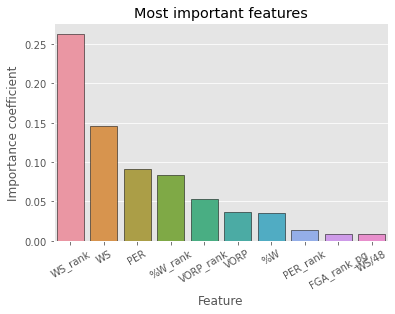

In [24]:
mod.display_feature_importances(best_model)

In [25]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)

(<Figure size 2880x2880 with 6 Axes>, <Figure size 2880x2880 with 6 Axes>)

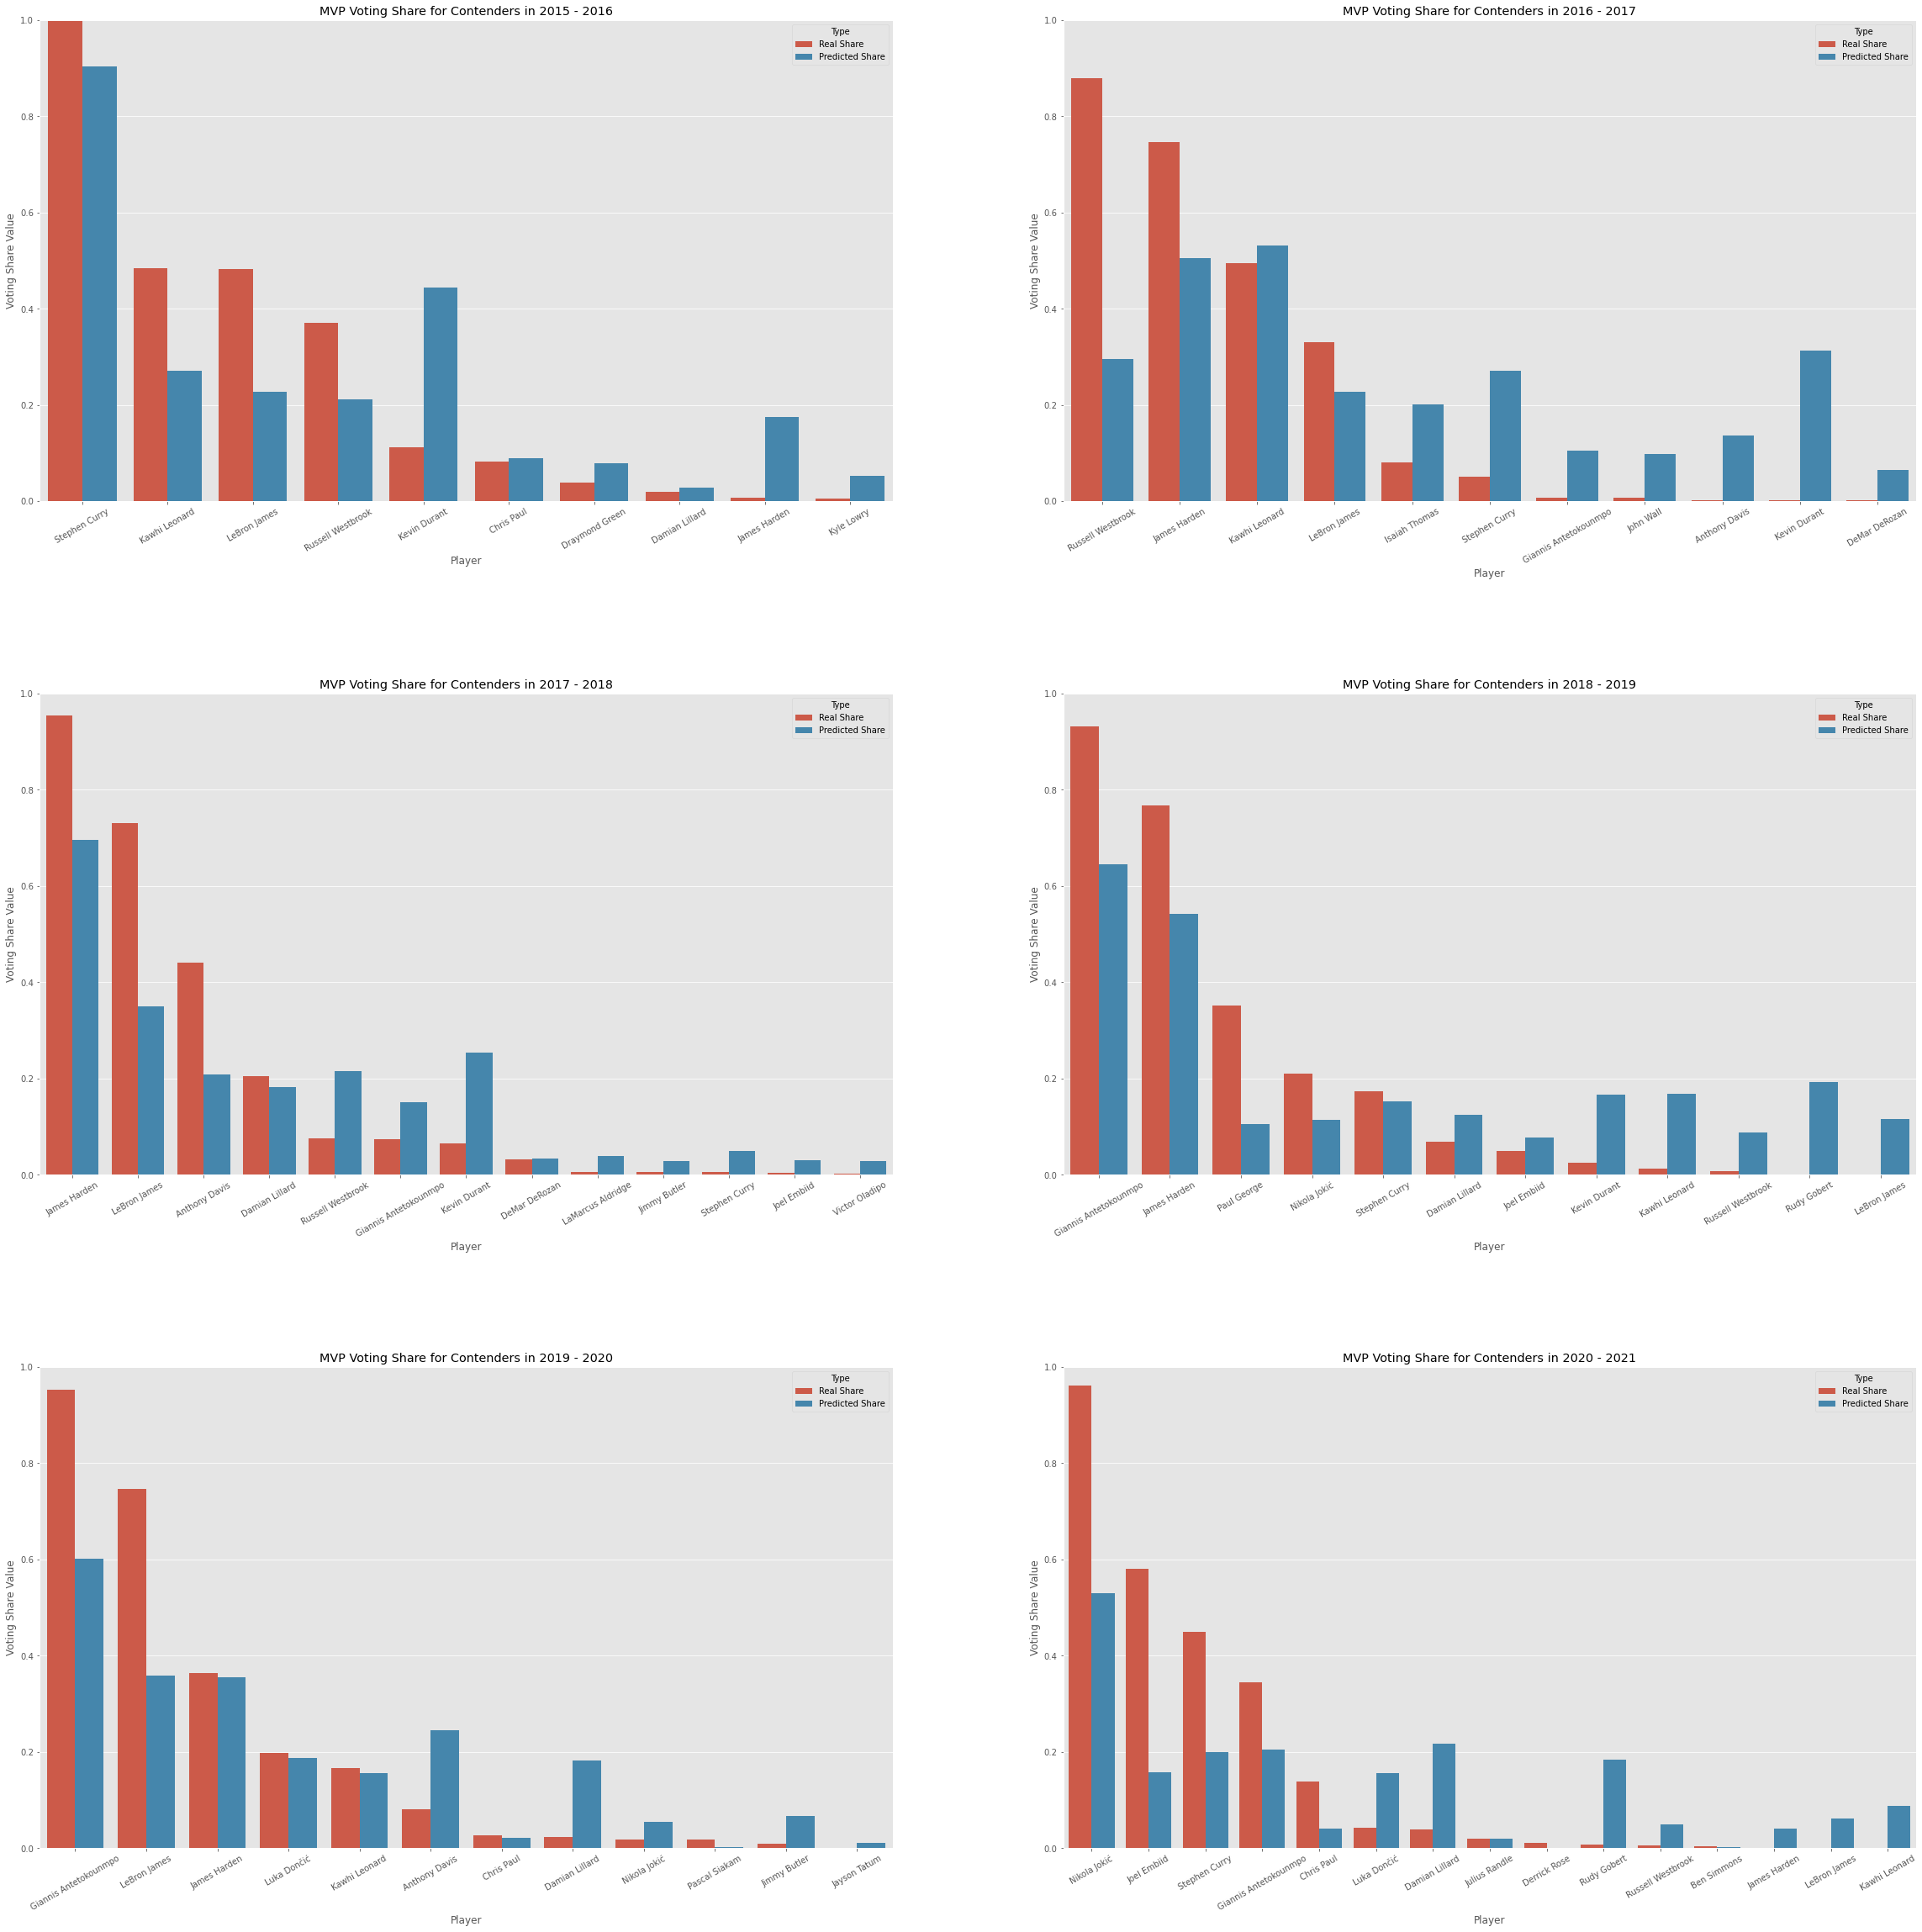

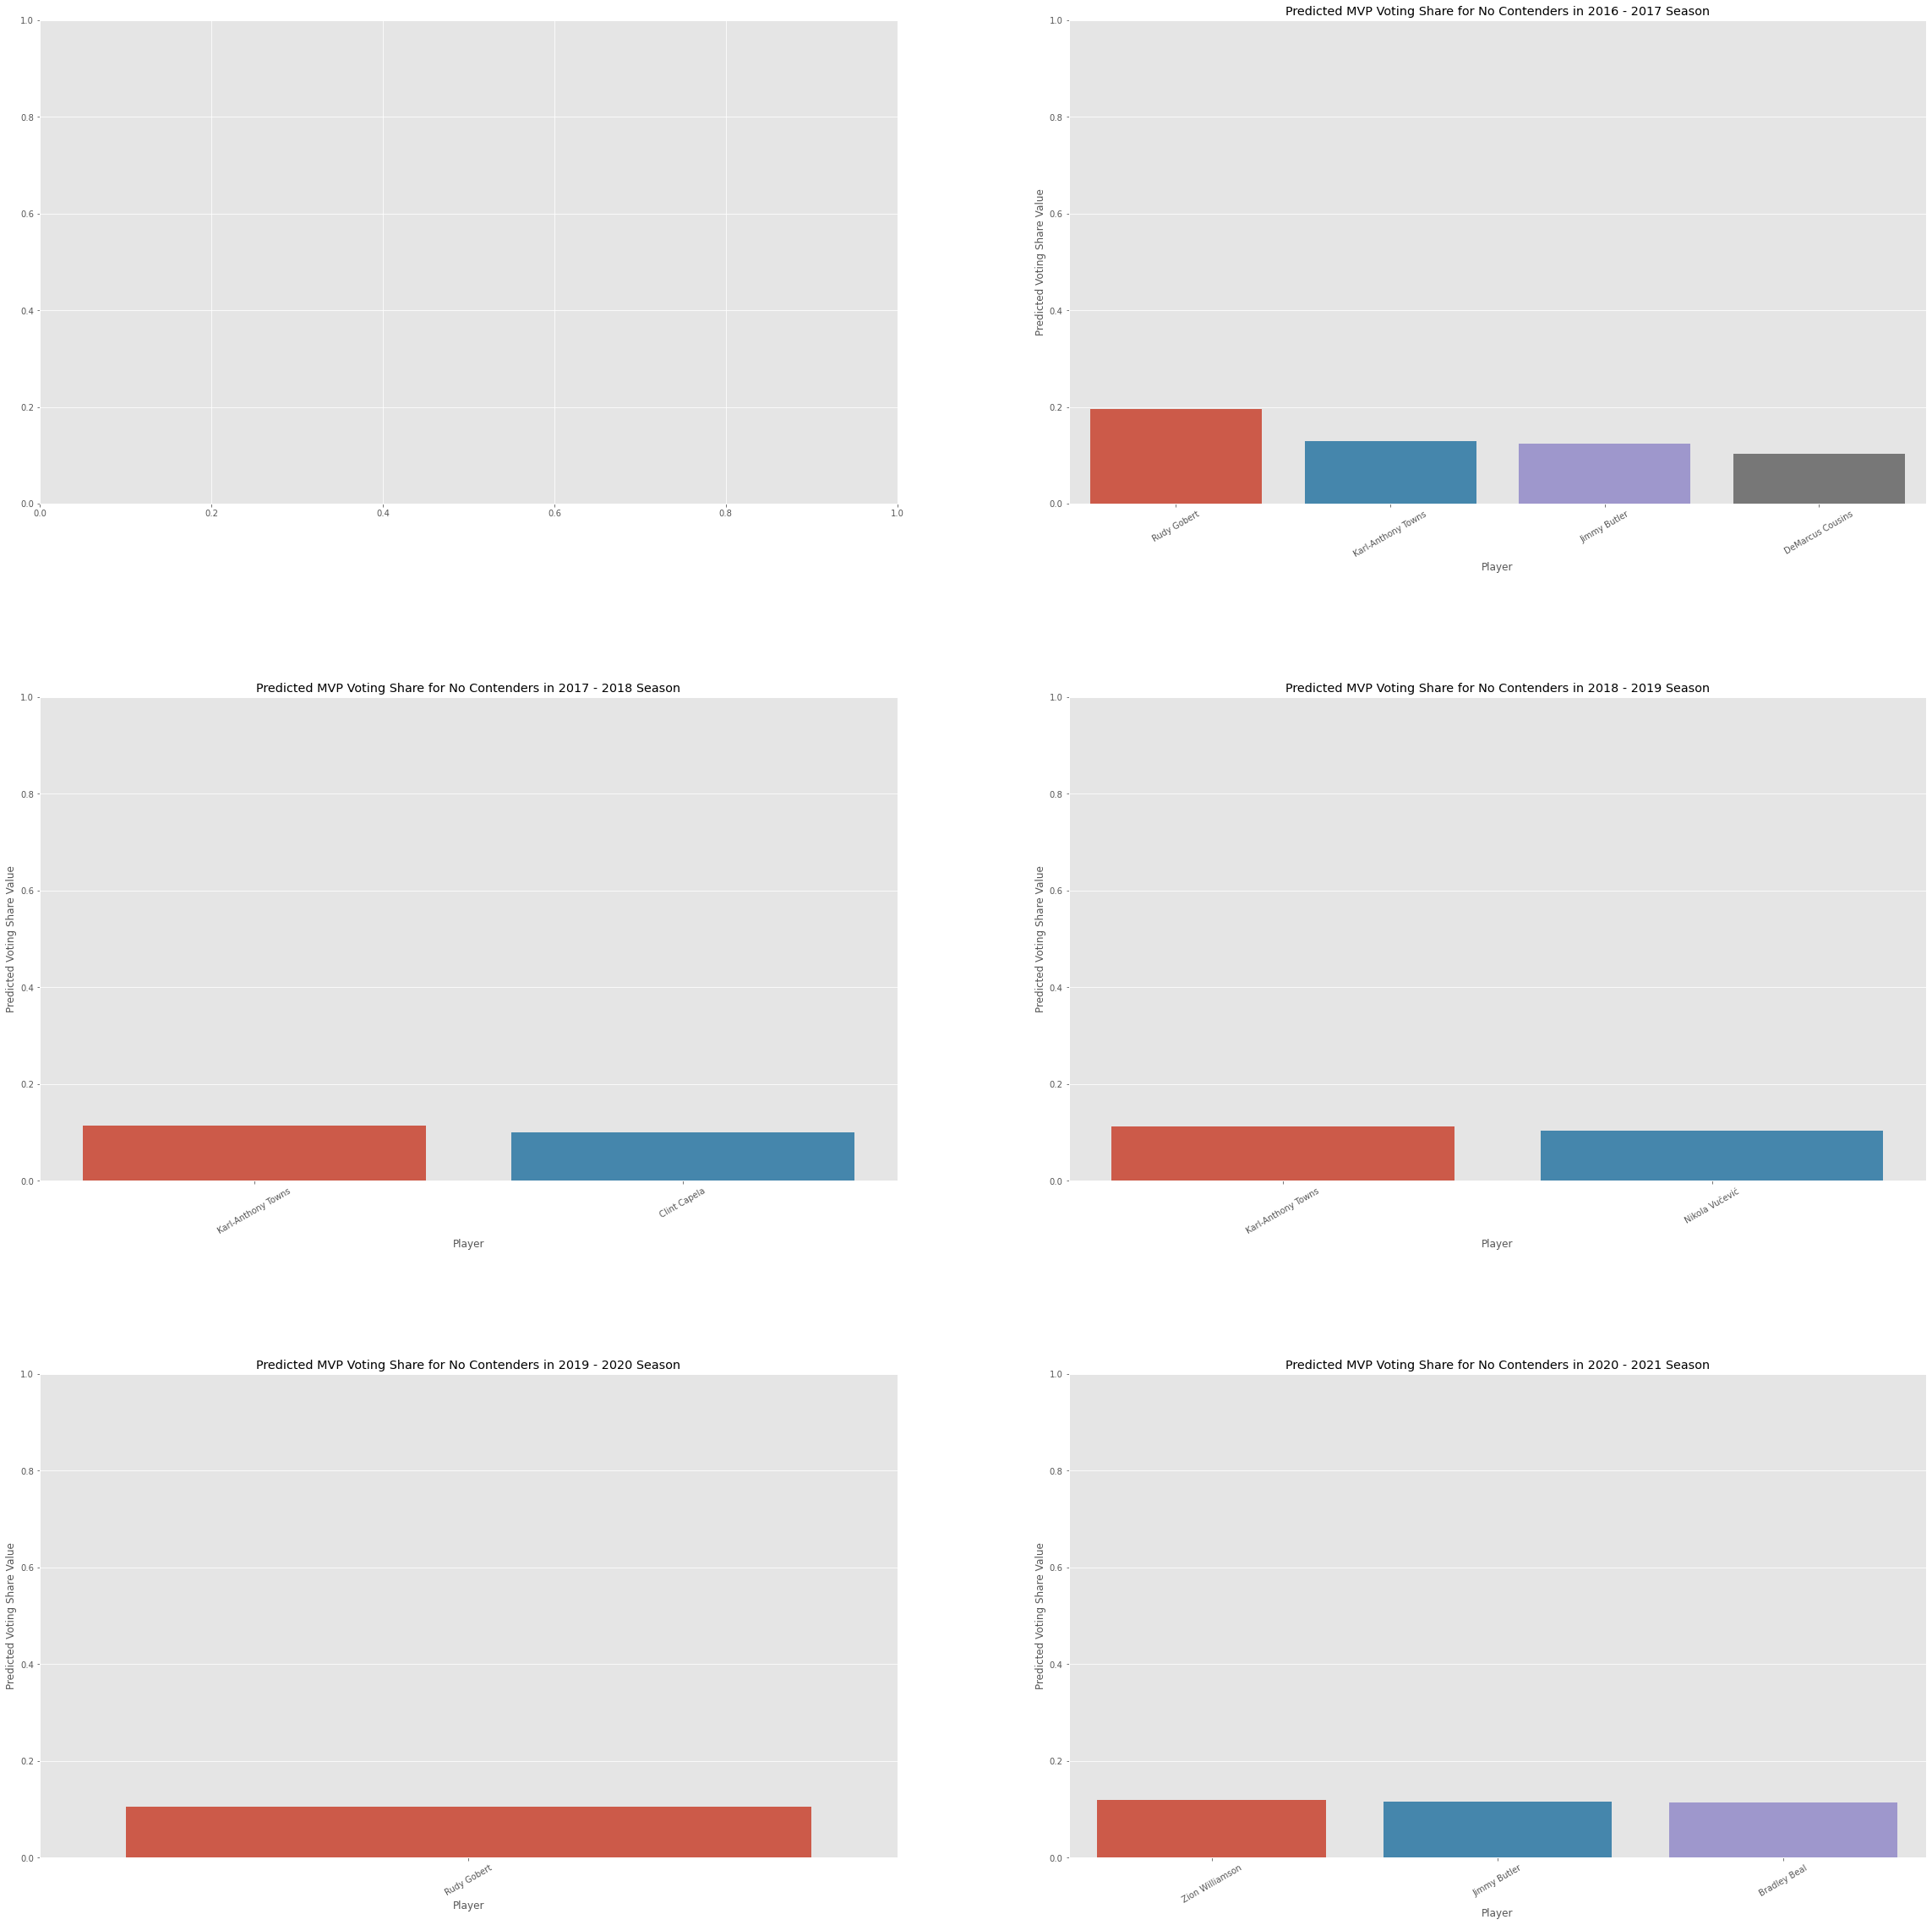

In [26]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list_)